In [2]:
from google.colab import drive
drive.mount('/content/my_drive')

Mounted at /content/my_drive


In [2]:
!nvidia-smi

Fri Apr 19 14:21:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [1]:
'''Import Libraries'''
import argparse
from argparse import ArgumentParser
import glob
import cv2
import re
import random
import math
import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract, Reshape, Attention
from keras.models import Model, load_model
from tensorflow.python.keras.utils import conv_utils
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

#import data_generator as dg
import keras.backend as K
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread, imsave


In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
'''Set Parameters'''
## Params
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='Deep_DeQuIP', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=10, type=int, help='batch size')

parser.add_argument('--train_data_clean', default='/content/my_drive/MyDrive/DIVA-Attention Test/train', type=str, help='path of train data clean')
parser.add_argument('--train_data_noisy', default='/content/my_drive/MyDrive/DIVA-Attention Test/bmode', type=str, help='path of train data noisy')

parser.add_argument('--kernel_size', default=5, type=int, help='Hamiltonian kernel size')
parser.add_argument('--patches_size', default=50, type=int, help='patch size')

parser.add_argument('--epoch', default=50, type=int, help='number of train epoches')
parser.add_argument('--lr', default=1e-3, type=float, help='initial learning rate for Adam')
parser.add_argument('--save_every', default=1, type=int, help='save model at every x epoches')
parser.add_argument('-f', '--file', required=False)

args = parser.parse_args()
#args.save_every = args.epoch


In [4]:
'''Set Save Dir for Models'''
save_dir = os.path.join('/content/my_drive/MyDrive/DIVA-Attention Test',
                        args.model+'_Base')

if not os.path.exists(save_dir):
  print(save_dir)
  os.mkdir(save_dir)


In [5]:
'''utility functions'''

def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir,'model_*.hdf5'))  # returns names of all .hdf5 files
    if file_list:
        epochs_exist = []
        for file in file_list:
            result = re.findall(".*model_(.*).hdf5.*",file) # returns epoch number from the model checkpoint file
            epochs_exist.append(int(result[0]))
        initial_epoch=max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch

def log(*args,**kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"),*args,**kwargs)

def lr_schedule(epoch):
    initial_lr = args.lr
    if epoch<=20:
        lr = initial_lr
    elif epoch<=30:
        lr = initial_lr/10
    elif epoch<=40:
        lr = initial_lr/20
    else:
        lr = initial_lr/20
    log('current learning rate is %2.8f' %lr)
    return lr


In [6]:
def train_datagen(epoch_iter=2000, epoch_num=5, batch_size=128, data_dir=args.train_data_noisy):
  #Original Batch_size = 128
  #Original iter = 2000
  n_count = 0 # AneeshFix
  while(True):
      # n_count = 0 AneeshError
      if n_count == 0:
          #print(n_count)
          #xs, ys = speckled_datagenerator(data_dir)  AneeshError?  # generate clean and noisy data
          clean_data, noisy_data = speckled_datagenerator(data_dir) #AneeshFix

          assert len(clean_data) % args.batch_size == 0, 'make sure the last iteration has a full batchsize, this is important if you use batch normalization!'

          # normalize the pixel values between 0 and 1
          clean_data = clean_data.astype('float32')/255.0
          noisy_data = noisy_data.astype('float32')/255.0

          indices = list(range(clean_data.shape[0]))
          n_count = 1

      for _ in range(epoch_num):
          np.random.shuffle(indices)
          for i in range(0, len(indices), batch_size):
              clean_batch = clean_data[indices[i:i+batch_size]]
              noisy_batch = noisy_data[indices[i:i+batch_size]]

             # noise =  np.random.normal(0, args.sigma/255.0, batch_x.shape)

              yield noisy_batch, clean_batch

In [7]:
def make_batch(data):
  data = np.array(data, dtype='uint8')
  data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],1))
  discard_n = len(data)-len(data) // batch_size*batch_size
  data = np.delete(data, range(discard_n), axis = 0)
  return data

In [8]:
def speckled_datagenerator(data_dir, verbose=False):

    file_list = glob.glob(data_dir+'/*.png')  # returns names of all .png files in B_Mode Dir
    #print('file_list', file_list)

    data = []
    data_clean = []

    # generate patches for all images in the directory
    for i in range(len(file_list)):
        clean_patch, patch = gen_speckled_image_patches(file_list[i])

        data.append(patch)
        data_clean.append(clean_patch)

        if verbose:
            print('image :',str(i+1)+'/'+ str(len(file_list)))

    # do for speckled data
    data = np.array(data, dtype='uint8')
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],1))
    discard_n = len(data)-len(data)//batch_size*batch_size
    data = np.delete(data,range(discard_n),axis = 0)

    # do for clean data
    data_clean = np.array(data_clean, dtype='uint8')
    data_clean = data_clean.reshape((data_clean.shape[0]*data_clean.shape[1],data_clean.shape[2],data_clean.shape[3],1))
    discard_n = len(data_clean)-len(data_clean)//batch_size*batch_size
    data_clean = np.delete(data_clean,range(discard_n),axis = 0)

    print('-----training data finished-----')
    print('noisy image shape:',data.shape)
    print('clean image shape:',data_clean.shape)

    assert data.shape == data_clean.shape


    return data_clean, data

In [9]:
import matplotlib.pyplot as plt
def gen_speckled_image_patches(file_name):

    last_name = file_name.split('_')[-1] #  Returns Name of the Image
    clean_image_file_name = os.path.join(args.train_data_clean, last_name) # clean train image directory

    img = cv2.imread(file_name, 0) # noisy image
    clean_img = cv2.imread(clean_image_file_name, 0) # clean image

    '''show(np.hstack((clean_img,img))) # display the images'''

    h, w = img.shape

    patches = []
    clean_patches = []

    for s in scales: # scaling the images
        h_scaled, w_scaled = int(h*s),int(w*s)
        img_scaled = cv2.resize(img, (h_scaled,w_scaled), interpolation=cv2.INTER_CUBIC)
        clean_img_scaled = cv2.resize(clean_img, (h_scaled,w_scaled), interpolation=cv2.INTER_CUBIC)

        # extract patches from the images '''ANEESH: PATCH 1 GETTING GENERATED'''
        for i in range(0, h_scaled-patch_size+1, stride):
            for j in range(0, w_scaled-patch_size+1, stride):
                patch = img_scaled[i:i+patch_size, j:j+patch_size]
                clean_patch = clean_img_scaled[i:i+patch_size, j:j+patch_size]

                # data augmentation
                for k in range(0, aug_times):
                  mode_k=np.random.randint(0,8)
                  patch_aug = data_augmentation(patch, mode=mode_k)
                  clean_patch_aug = data_augmentation(clean_patch, mode=mode_k)
                  patches.append(patch_aug)
                  clean_patches.append(clean_patch_aug)




    return clean_patches, patches

In [10]:
'''Data Augmentation'''
def data_augmentation(img, mode=0):
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

In [11]:

'''Show Images'''
def show(x,title=None,cbar=False,figsize=None):
    plt.figure(figsize=figsize)
    plt.imshow(x,interpolation='nearest',cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

In [12]:
'''Loss Function'''
def sum_squared_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1)
    #return K.sum(K.square(y_pred - y_true), axis=-1)/2
    return K.sum(K.square(y_pred - y_true))/2

In [13]:
'''DIVA2D Model'''
def DIVA2D(depth,filters=64,image_channels=1, kernel_size=5, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))

    # Get the initial patches /initial_patches '''ANEESH: SMALLER PATCHES GENERATED FROM BIGGER PATCHES BY GENERATE_PATCH FUNCTION, IMAGE DIMENSION REMAINS SAME'''
    initial_patches = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'initial_patches')(inpt)
    initial_patches = Activation('relu',name = 'initial_patch_acti')(initial_patches)
    #print(initial_patches.get_shape())



    # interaction layer ANEESH: REPLACE BY ATTENTION? PREPEND / APPEND ATTENTION?
    inter = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'interactions')(initial_patches)
    inter = Activation('relu',name = 'interaction_acti'+str(layer_count))(inter)
    #print(inter.get_shape())

    # Get contributions of the original potential in the Hamiltonian kernel ANEESH: Ja from DIVA Diagram
    ori_poten_kernel = tf.keras.layers.MaxPooling2D (pool_size=(21,21), strides=(15,15), padding='same', name = 'ori_poten_ker', data_format=None )(initial_patches)
    #print('ori_poten_kernel',ori_poten_kernel.get_shape())

    # Get contributions of the interactions in the Hamiltonian kernel ANEESH: Ia from DIVA Diagram
    inter_kernel = tf.keras.layers.MaxPooling2D (pool_size=(21,21), strides=(15,15), padding='same', name = 'inter_ker', data_format=None )(inter)
    #print('inter_kernel',inter_kernel.get_shape())


    # Get projection coefficients of the initial patches on the Hamiltonian kernel
    x = Hamiltonian_Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), kernel_3 = ori_poten_kernel, kernel_4 = inter_kernel, strides=(1,1), activation='relu',
                              kernel_initializer='Orthogonal', padding='same', name = 'proj_coef')(initial_patches)

    #print('coef',x.get_shape())


    # Do Thresholding (depth depends on the noise intensity)
    for i in range(depth):
      layer_count += 1
      x = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)

      layer_count += 1
      x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        #x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)

      # Thresholding
      x = Activation('relu',name = 'Thresholding'+str(layer_count))(x)

    # Inverse projection
    x = Conv2D(filters=image_channels, kernel_size=(kernel_size,kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'inv_trans')(x)


    # Deconvolution layer ANEESH: NEUTRALIZATION LAYER SIMILAR TO DIVA-A?
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(args.kernel_size,args.kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'deconv'+str(layer_count))(x)
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(args.kernel_size,args.kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'deconv'+str(layer_count))(x)
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(args.kernel_size,args.kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'deconv'+str(layer_count))(x)
    layer_count += 1


    x = Subtract(name = 'subtract')([inpt, x])   # input - noise '''ANEESH: Noisy Image is getting subtracted from the Denoised Image'''

    model = Model(inputs=inpt, outputs=x)

    return model

In [14]:
 '''Hamiltonian convolution layer'''
class Hamiltonian_Conv2D(Conv2D):

    def __init__(self, filters, kernel_size, kernel_3=None, kernel_4=None, activation=None, use_bias = False, **kwargs):

        self.rank = 2               # Dimension of the kernel
        self.num_filters = filters  # Number of filter in the convolution layer
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, self.rank, 'kernel_size')
        self.kernel_3 = kernel_3    # Weights from original potential
        self.kernel_4 = kernel_4    # Weights from interaction

        super(Hamiltonian_Conv2D, self).__init__(self.num_filters, self.kernel_size,
              activation=activation, use_bias=False, **kwargs)

    def build(self, input_shape):
        if K.image_data_format() == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                     'should be defined. Found `None`.')

        #don't use bias:
        self.bias = None

        #consider the layer built
        self.built = True


        # Define nabla operator
        weights_1 = tf.constant([[ 2.,-1., 0.],
                                 [-1., 4.,-1.],
                                 [ 0.,-1., 2.]])


        weights_1 = tf.reshape(weights_1 , [3,3, 1])
        weights_1 = tf.repeat(weights_1 , repeats=self.num_filters, axis=2)
        #print('kernel shape of weights_1:',weights_1.get_shape())

        # Define Weights for h^2/2m  (size should be same as the nabla operator)
        weights_2 = self.add_weight(shape=weights_1.get_shape(),
                                      initializer= 'Orthogonal',
                                      name='kernel_h^2/2m',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        #print('kernel shape of weights_2:',weights_2.get_shape())


        # Define the Hamiltonian kernel
        self.kernel = weights_1*weights_2 + self.kernel_3 + self.kernel_4
        #print('self.kernel',self.kernel.get_shape())

        self.built = True
        super(Hamiltonian_Conv2D, self).build(input_shape)

    # Do the 2D convolution using the Hamiltonian kernel
    def convolution_op(self, inputs, kernel):
        if self.padding == "causal":
            tf_padding = "VALID"  # Causal padding handled in `call`.
        elif isinstance(self.padding, str):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding


        return tf.nn.convolution(
            inputs,
            kernel,
            strides=list(self.strides),
            padding=tf_padding,
            dilations=list(self.dilation_rate),
            name=self.__class__.__name__,
        )

    def call(self, inputs):
        outputs = self.convolution_op(inputs, self.kernel)
        return outputs


In [15]:
model = DIVA2D(depth=15,filters=96,image_channels=1,use_bnorm=True)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input0 (InputLayer)         [(None, None, None, 1)]      0         []                            
                                                                                                  
 initial_patches (Conv2D)    (None, None, None, 96)       2496      ['input0[0][0]']              
                                                                                                  
 initial_patch_acti (Activa  (None, None, None, 96)       0         ['initial_patches[0][0]']     
 tion)                                                                                            
                                                                                                  
 proj_coef (Hamiltonian_Con  (None, None, None, 96)       231264    ['initial_patch_acti[0][0]

In [17]:
'''Hyperparameters'''
patch_size, stride = 50, 10
aug_times = 1
scales = [1] # [1, 0.9, 0.8, 0.7]
batch_size = 10

In [20]:
if __name__ == '__main__':
    # model selection
    model = DIVA2D(depth=15,filters=96,image_channels=1,use_bnorm=True)
    #model.summary()

    # load the last model in matconvnet style
    initial_epoch = findLastCheckpoint(save_dir=save_dir)
    if initial_epoch > 0:
        print('resuming by loading epoch %03d'%initial_epoch)
        model.load_weights(os.path.join(save_dir,'model_%03d.hdf5'%initial_epoch))

    # compile the model
    model.compile(optimizer=Adam(0.001), loss= tf.keras.losses.MeanSquaredError(), #tf.keras.losses.CosineSimilarity (axis=-1, reduction="auto", name="cosine_similarity"),
                  metrics=[tf.keras.metrics.MeanSquaredError(),
                           tf.keras.metrics.RootMeanSquaredError(),
                           tf.keras.metrics.MeanSquaredLogarithmicError(),
                           tf.keras.metrics.MeanAbsoluteError(),
                           sum_squared_error])

    # tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.CosineSimilarity(name="cosine_similarity", dtype=None, axis=-1),
    # tf.keras.metrics.LogCoshError(),

    # use call back functions
    checkpointer = ModelCheckpoint(os.path.join(save_dir,'model_{epoch:03d}.hdf5'),
                verbose=1, save_weights_only=False, period=1)
    csv_logger = CSVLogger(os.path.join(save_dir,'log.csv'), append=True, separator=',')
    lr_scheduler = LearningRateScheduler(lr_schedule)

    print('batch_size = ',args.batch_size)
    history = model.fit(train_datagen(batch_size=args.batch_size),
                steps_per_epoch=1500, epochs=5, verbose=1, initial_epoch=initial_epoch,
                callbacks=[checkpointer,csv_logger,lr_scheduler])
    #steps_per_epoch = 7000, epochs = 50

batch_size =  10
-----training data finished-----
noisy image shape: (13690, 50, 50, 1)
clean image shape: (13690, 50, 50, 1)
2024-04-19 15:40:52: current learning rate is 0.00100000
Epoch 1/5


1500/1500 [==============================] - ETA: 0s - loss: 0.4267 - mean_squared_error: 0.4267 - root_mean_squared_error: 0.6532 - mean_squared_logarithmic_error: 0.0163 - mean_absolute_error: 0.1332 - sum_squared_error: 5333.5332
Epoch 1: saving model to /content/my_drive/MyDrive/DIVA-Attention Test/Deep_DeQuIP_Base/model_001.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 171s 103ms/step - loss: 0.4267 - mean_squared_error: 0.4267 - root_mean_squared_error: 0.6532 - mean_squared_logarithmic_error: 0.0163 - mean_absolute_error: 0.1332 - sum_squared_error: 5333.5332 - lr: 0.0010
2024-04-19 15:43:43: current learning rate is 0.00100000
Epoch 2/5
1500/1500 [==============================] - ETA: 0s - loss: 0.0192 - mean_squared_error: 0.0192 - root_mean_squared_error: 0.1385 - mean_squared_logarithmic_error: 0.0109 - mean_absolute_error: 0.1082 - sum_squared_error: 239.8564
Epoch 2: saving model to /content/my_drive/MyDrive/DIVA-Attention Test/Deep_DeQuIP_Base/model_002.hdf5
1500/1500 [==============================] - 153s 102ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - root_mean_squared_error: 0.1385 - mean_squared_logarithmic_error: 0.0109 - mean_absolute_error: 0.1082 - sum_squared_error: 239.8564 - lr: 0.0010
2024-04-19 15:46:16: current learning rate is 0.00100000
Epoch 3/5
1500/1500 [=============

In [ ]:
'''saves the history of the model as a binary file'''
import pickle

# Save history to a file
with open('/content/my_drive/MyDrive/CNRS Research/Deep_DeQuIP_100_F/training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_squared_logarithmic_error', 'mean_absolute_error', 'sum_squared_error', 'lr'])


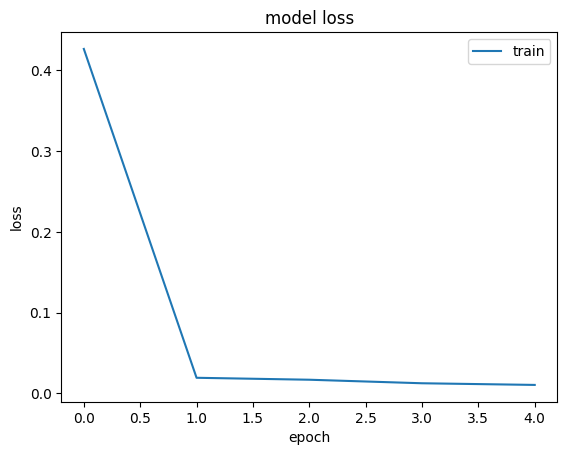

In [21]:
# list all data in history
print(history.history.keys())
# summarize history for loss
#plt.plot((history.history['loss']))
plt.plot((history.history['mean_squared_error']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
#1622.84 min sum_square_error -> v1 train 50 epoch, 2500 steps, 256 batches

In [ ]:
from google.colab import runtime
runtime.unassign()